# Setting up GPU

In [6]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=3


In [8]:
!pip list

Package                      Version
---------------------------- -------------
absl-py                      2.0.0
anyio                        4.0.0
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.3.0
asttokens                    2.4.1
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        23.1.0
Babel                        2.13.1
beautifulsoup4               4.12.2
bleach                       6.1.0
blinker                      1.4
cachetools                   5.3.2
certifi                      2023.11.17
cffi                         1.16.0
charset-normalizer           3.3.2
comm                         0.2.0
contourpy                    1.2.0
cryptography                 3.4.8
cycler                       0.12.1
dbus-python                  1.2.18
debugpy                      1.8.0
decorator                    5.1.1
defusedxml                   0.7.1
distro                       1.7.0

# Imports 

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/dev/null'
import cv2
import pathlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score, recall_score, precision_score
from tensorflow.keras.applications import VGG16
from scipy.linalg import sqrtm
from sklearn.metrics.pairwise import polynomial_kernel
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore", message="No artists with labels found to put in legend.")  
warnings.filterwarnings("ignore", category=FutureWarning)
SEED = 36
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Loading Data

In [3]:
class ReadDataset:
    def __init__(self, datasetpath, labels, image_shape):
        self.datasetpath = datasetpath
        self.labels = labels
        self.image_shape = image_shape
    def returListImages(self,):
        self.images = []
        for label in self.labels:
            self.images.append(list(pathlib.Path(os.path.join(self.datasetpath,
                                                              label)).glob('*.*')))
    def readImages(self,):
        self.returListImages()
        self.finalImages = []
        labels = []
        for label in range(len(self.labels)):
            for img in self.images[label]:
                img = cv2.imread(str(img), cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue
                img = cv2.resize(img , self.image_shape[:2])
                img  = img/255
                img = np.expand_dims(img, axis=-1)  # Add channel dimension to get shape (64, 64, 1)
                self.finalImages.append(img)
                labels.append(label)
        images = np.array(self.finalImages)
        labels = np.array(labels)
        return images, labels

In [4]:
readDatasetObject = ReadDataset('chest_xray/train',
                               ['NORMAL', 'PNEUMONIA'],
                               (64, 64))
images, labels = readDatasetObject.readImages()
images.shape, labels.shape

((5216, 64, 64, 1), (5216,))

# Defining the VAE module

In [5]:
class CVAE(Model):
    def __init__(self, latent_dim, num_classes, input_shape):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # Encoder network
        self.encoder_inputs = layers.Input(shape=(input_shape[0], input_shape[1], 1))
        self.label_inputs = layers.Input(shape=(num_classes,))
        
        x = layers.Conv2D(32, (3, 3), activation='relu', strides=2, padding='same')(self.encoder_inputs)
        x = layers.Conv2D(64, (3, 3), activation='relu', strides=2, padding='same')(x)
        x = layers.Flatten()(x)
        x = layers.Concatenate()([x, self.label_inputs])
        x = layers.Dense(128, activation='relu')(x)
        
        self.z_mean = layers.Dense(latent_dim)(x)
        self.z_log_var = layers.Dense(latent_dim)(x)

        # Decoder network
        self.decoder_inputs = layers.Input(shape=(latent_dim,))
        self.decoder_labels = layers.Input(shape=(num_classes,))
        x = layers.Concatenate()([self.decoder_inputs, self.decoder_labels])
        x = layers.Dense(16 * 16 * 64, activation='relu')(x)
        x = layers.Reshape((16, 16, 64))(x)
        x = layers.Conv2DTranspose(64, (3, 3), activation='relu', strides=2, padding='same')(x)
        x = layers.Conv2DTranspose(32, (3, 3), activation='relu', strides=2, padding='same')(x)
        decoder_outputs = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

        self.encoder = Model([self.encoder_inputs, self.label_inputs], [self.z_mean, self.z_log_var])
        self.decoder = Model([self.decoder_inputs, self.decoder_labels], decoder_outputs)

    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(self.latent_dim,))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x, labels):
        z_mean, z_log_var = self.encoder([x, labels])
        eps = tf.random.normal(shape=z_mean.shape)
        z = z_mean + tf.exp(0.5 * z_log_var) * eps
        return z, z_mean, z_log_var

    def decode(self, z, labels, apply_sigmoid=False):
        logits = self.decoder([z, labels])
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

    def call(self, inputs):
        x, labels = inputs
        z, z_mean, z_log_var = self.encode(x, labels)
        reconstructed = self.decode(z, labels)
        return reconstructed, z_mean, z_log_var

# Example usage
latent_dim = 16
num_classes = 2
input_shape = (64, 64)

cvae = CVAE(latent_dim, num_classes, input_shape)

# Training

In [6]:
# Loss function
def compute_loss(model, x, labels):
    z, z_mean, z_log_var = model.encode(x, labels)
    x_reconstructed = model.decode(z, labels)
    reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(x, x_reconstructed), axis=(1, 2)))
    kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
    return reconstruction_loss + kl_loss

# Training step
@tf.function
def train_step(model, x, labels, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x, labels)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

# Convert labels to one-hot encoding
def one_hot_encode_labels(labels, num_classes):
    return tf.one_hot(labels, num_classes)

# Prepare the dataset
images = np.array(images).astype('float32')
labels = one_hot_encode_labels(labels, num_classes)

# Create a TensorFlow dataset
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices((images, labels)).shuffle(10000).batch(batch_size)

# Optimizer
optimizer = Adam(learning_rate=1e-3)

# Training loop
epochs = 351
for epoch in range(epochs):
    for x_batch, labels_batch in dataset:
        x_batch = tf.convert_to_tensor(x_batch)
        labels_batch = tf.convert_to_tensor(labels_batch)
        train_step(cvae, x_batch, labels_batch, optimizer)
    if epoch %50 == 0:
        print(f'Epoch {epoch} completed')




I0000 00:00:1729193439.322022  580755 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 0 completed
Epoch 50 completed
Epoch 100 completed
Epoch 150 completed
Epoch 200 completed
Epoch 250 completed
Epoch 300 completed
Epoch 350 completed


# Evaluation

In [7]:
def calculate_fid(real_images, generated_images):
    import numpy as np
    from scipy.linalg import sqrtm
    from keras.applications.inception_v3 import InceptionV3, preprocess_input
    import tensorflow as tf

    # Resize images to 299x299
    real_images_resized = tf.image.resize(real_images, (299, 299), method='bicubic')
    generated_images_resized = tf.image.resize(generated_images, (299, 299), method='bicubic')

    # Load InceptionV3 model
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

    # Get activations
    act_real = model.predict(real_images_resized)
    act_gen = model.predict(generated_images_resized)

    # Calculate mean and covariance
    mu_real, sigma_real = np.mean(act_real, axis=0), np.cov(act_real, rowvar=False)
    mu_gen, sigma_gen = np.mean(act_gen, axis=0), np.cov(act_gen, rowvar=False)

    # Calculate FID score
    ssdiff = np.sum((mu_real - mu_gen) ** 2)
    covmean = sqrtm(sigma_real.dot(sigma_gen))

    # Numerical error handling
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma_real + sigma_gen - 2 * covmean)
    return fid

In [8]:
def calculate_kid(real_images, generated_images):
    import numpy as np
    from scipy.linalg import sqrtm
    from sklearn.metrics.pairwise import polynomial_kernel
    from keras.applications.inception_v3 import InceptionV3, preprocess_input
    import tensorflow as tf

    # Resize images to 299x299 pixels
    real_images_resized = tf.image.resize(real_images, (299, 299), method='bicubic')
    generated_images_resized = tf.image.resize(generated_images, (299, 299), method='bicubic')


    # Load pre-trained InceptionV3 model
    inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

    # Get the activations
    act_real = inception_model.predict(real_images_resized)
    act_gen = inception_model.predict(generated_images_resized)

    # Compute polynomial kernels
    kernel_real = polynomial_kernel(act_real, degree=3, gamma=None, coef0=1)
    kernel_gen = polynomial_kernel(act_gen, degree=3, gamma=None, coef0=1)
    kernel_cross = polynomial_kernel(act_real, act_gen, degree=3, gamma=None, coef0=1)

    m = len(act_real)
    n = len(act_gen)

    # Calculate KID score
    kid = (np.sum(kernel_real) / (m * m)) + (np.sum(kernel_gen) / (n * n)) - (2 * np.sum(kernel_cross) / (m * n))
    return kid


In [9]:
def convert_grayscale_to_rgb(images):
    # Convert numpy array to TensorFlow tensor
    images_tensor = tf.convert_to_tensor(images)
    # Convert grayscale images to RGB
    return tf.image.grayscale_to_rgb(images_tensor)


In [10]:
def normalize_tensor(tensor):
    # Find the minimum and maximum values of the tensor
    min_val = tf.reduce_min(tensor)
    max_val = tf.reduce_max(tensor)
    
    # Normalize the tensor to [0, 1]
    normalized_tensor = (tensor - min_val) / (max_val - min_val)
    
    # Scale the normalized tensor to [-1, 1]
    normalized_tensor_neg_one_to_one = (normalized_tensor * 2) - 1
    
    return normalized_tensor_neg_one_to_one


In [11]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def plot_images(images, num_images=20, image_size=(64, 64), title="Generated Images"):
    # Calculate the grid size
    grid_size = int(np.ceil(np.sqrt(num_images)))
    
    # Create the plot
    plt.figure(figsize=(grid_size * 2, grid_size * 2))
    
    for i in range(num_images):
        ax = plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
    
    if title:
        plt.suptitle(title, fontsize=16)
    
    plt.show()

# Generate synthetic images on CPU
with tf.device('/CPU:0'):  # Ensure operations run on the CPU
    latent_vectors = np.random.normal(size=(30000, latent_dim))  # Generate random latent vectors
    newlabels = tf.keras.utils.to_categorical(np.random.choice([0, 1], size=(30000,)), num_classes=2)

    # Generate synthetic images using the decoder from the CVAE model on CPU
    generated_images = []
    batch_size = 1000  # Adjust the batch size to prevent memory exhaustion
    for i in range(0, 30000, batch_size):
        latent_batch = latent_vectors[i:i+batch_size]
        label_batch = newlabels[i:i+batch_size]
        generated_images_batch = cvae.decode(latent_batch, label_batch, apply_sigmoid=True)
        generated_images.append(generated_images_batch)
    
    generated_images = np.concatenate(generated_images, axis=0)

images_normalized = normalize_tensor(images)
imagesGeneration_normalized = normalize_tensor(generated_images)

# Convert grayscale images to RGB
real_images_rgb = convert_grayscale_to_rgb(images_normalized)
generated_images_rgb = convert_grayscale_to_rgb(imagesGeneration_normalized)

# Calculate FID and KID scores
fid_score = calculate_fid(real_images_rgb, generated_images_rgb)
kid_score = calculate_kid(real_images_rgb, generated_images_rgb)

print(f'FID Score: {fid_score}')
print(f'KID Score: {kid_score}')



938/938 [==============================] - 38s 39ms/step
FID Score: 208.8815007662104
KID Score: 0.25222301737145614


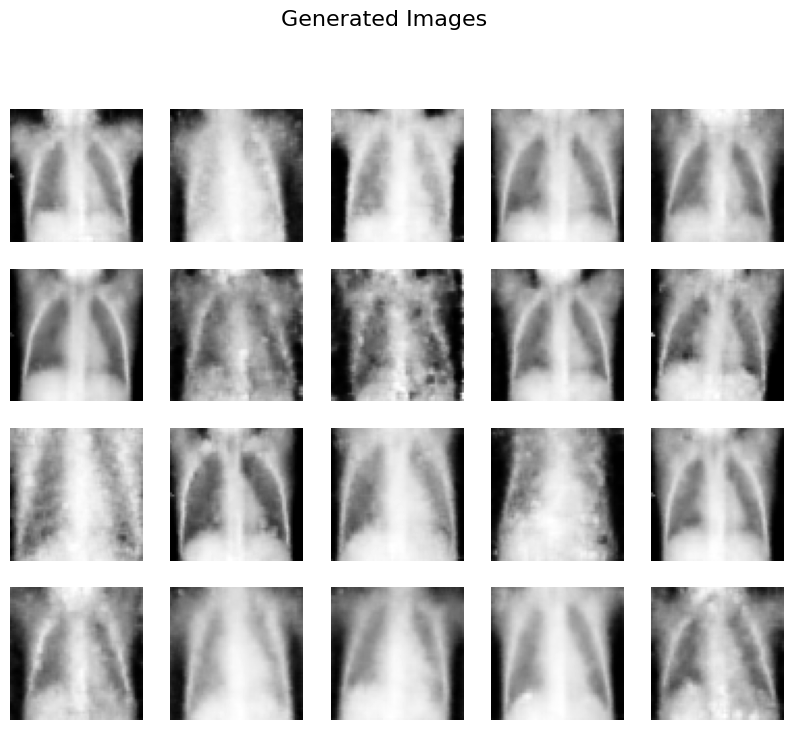

In [12]:
plot_images(generated_images)

In [13]:
# Convert TensorFlow tensors to NumPy arrays if necessary
#generated_images = generated_images.numpy()
basemodel = tf.keras.applications.VGG16(weights = None, input_shape = (64, 64, 1),
                                        pooling = 'max', include_top = False)
x = layers.Dropout(0.4)(basemodel.output)
x = layers.Dense(128,)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha = 0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(32,)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha = 0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1, activation = 'sigmoid')(x)
m = tf.keras.models.Model(inputs = basemodel.input, outputs = x)
m.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00002))
m.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        640       
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [14]:
history = m.fit(generated_images, np.argmax(newlabels, axis = 1),
                epochs = 60, batch_size = 64,
                validation_split = 0.2,
                callbacks = [tf.keras.callbacks.EarlyStopping(patience = 3, monitor = 'val_loss', mode = 'min',
                                                              restore_best_weights = True)])

Epoch 1/60
375/375 [==============================] - 21s 35ms/step - loss: 0.3028 - val_loss: 0.5035
Epoch 2/60
375/375 [==============================] - 12s 31ms/step - loss: 0.0589 - val_loss: 0.0376
Epoch 3/60
375/375 [==============================] - 11s 30ms/step - loss: 0.0439 - val_loss: 0.0224
Epoch 4/60
375/375 [==============================] - 11s 30ms/step - loss: 0.0372 - val_loss: 0.0112
Epoch 5/60
375/375 [==============================] - 12s 31ms/step - loss: 0.0298 - val_loss: 0.0330
Epoch 6/60
375/375 [==============================] - 11s 31ms/step - loss: 0.0278 - val_loss: 0.0138
Epoch 7/60
375/375 [==============================] - 12s 31ms/step - loss: 0.0250 - val_loss: 0.0177


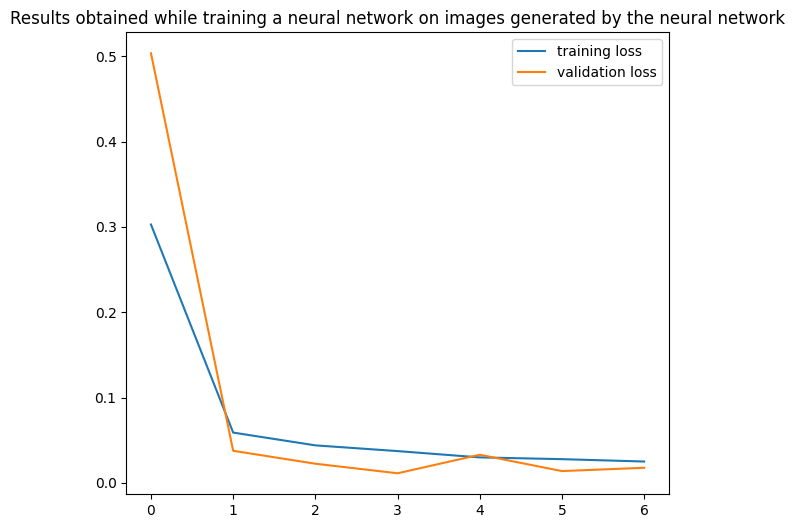

In [15]:
plt.figure(figsize = (7, 6))
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.title('Results obtained while training a neural network on images generated by the neural network')
plt.legend()

In [16]:
readDatasetObject = ReadDataset('/tf/chest_xray/test',
                               ['NORMAL', 'PNEUMONIA'],
                               (64, 64))
images_test, labels_test = readDatasetObject.readImages()

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
def calculate_metrics(model, images, labels):
    loss = model.evaluate(images, labels, verbose=0)  
    y_pred = tf.squeeze(model.predict(images))
    y_pred = y_pred >= 0.5
    y_pred = np.array(y_pred, dtype='int32')
    labels = np.array(labels, dtype='int32')
    acc = accuracy_score(y_pred, labels) * 100
    f1 = f1_score(y_pred, labels) * 100
    recall = recall_score(y_pred, labels) * 100
    precision = precision_score(y_pred, labels) * 100
    cm = confusion_matrix(y_pred, labels)
    cmObject = pd.DataFrame(cm , index = ['NORMAL', 'PNEUMONIA'],
                        columns = ['NORMAL', 'PNEUMONIA'])
    sns.heatmap(cmObject, annot = True, cmap="Blues")
    return {
        'accuracy': acc,
        'f1_score': f1,
        'recall': recall,
        'precision': precision,
        'confusion_matrix': cm
    }


20/20 [==============================] - 0s 6ms/step
1:1 Ratio -> Accuracy: 79.65%, F1 Score: 81.78%, Recall: 92.83%, Precision: 73.08%


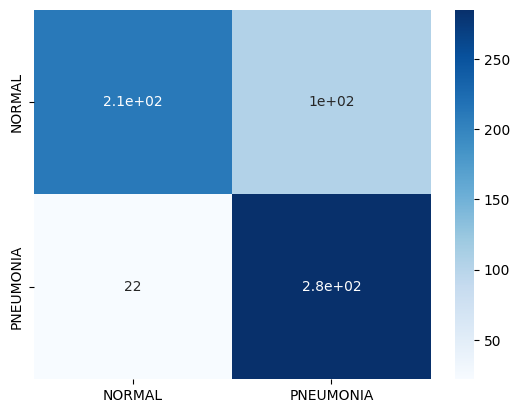

In [18]:
metrics = calculate_metrics(m, images_test, labels_test)
print(f"1:1 Ratio -> Accuracy: {metrics['accuracy']:.2f}%, F1 Score: {metrics['f1_score']:.2f}%, "
      f"Recall: {metrics['recall']:.2f}%, Precision: {metrics['precision']:.2f}%")

In [19]:
print(metrics['confusion_matrix'])

[[212 105]
 [ 22 285]]
